## Cartopy を利用した地理情報の可視化

[Cartopy](http://scitools.org.uk/cartopy/) は地図生成や地理空間可視化を目的とした地理空間データ処理パッケージである。

以下の例は、Cartopy を利用して、[Natural Earth](http://www.naturalearthdata.com) から日本の都道府県の境界データを取得し、
matplotlib の patch を作成、描画するプログラムである:

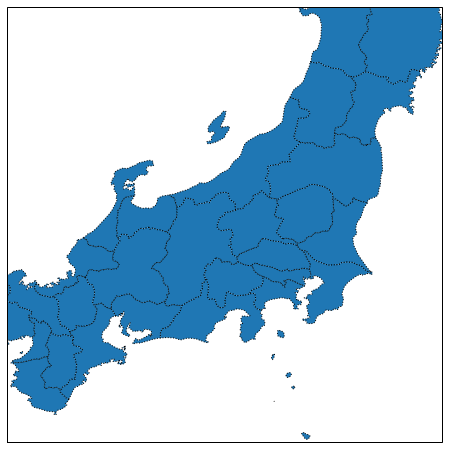

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader

# 10m 解像度のデータ読み込み
shpfilename = shapereader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_1_states_provinces')

# 国内の都道府県のみ取得
reader = shapereader.Reader(shpfilename)
provinces = []
for province in reader.records():
    if(province.attributes["admin"] == "Japan"):
        provinces.append(province)

# Figure, Subplot 生成
plt.figure(figsize=[8,8])
ax = plt.axes(projection=ccrs.PlateCarree())

# 都道府県のパッチで埋めていく
for province in provinces:
    geometry = province.geometry
    ax.add_geometries(geometry, ccrs.PlateCarree(), edgecolor="black", linestyle=":")

# 日本以外を含む海岸線を描画
# ax.coastlines(resolution='10m')

# 描画範囲を緯度、経度で指定
ax.set_extent([135, 142, 33, 40])
plt.show()

都道府県データから、英語名 "name"、日本語名 "name_local" を確認してみる。残念ながら　"Shizuoka" に対応する日本語名はないようだ:

In [2]:
for province in provinces:
    print(province.attributes["name"], province.attributes["name_local"])

Kagoshima 鹿児島県
Ōita 大分県
Fukuoka 福岡県
Saga 佐賀県
Nagasaki 長崎県
Kumamoto 熊本県
Miyazaki 宮崎県
Tokushima 徳島県
Kagawa 香川県
Ehime 愛媛県
Kōchi 高知県
Shimane 島根県
Yamaguchi 山口県
Tottori 鳥取県
Hyōgo 兵庫県
Kyōto 京都府
Fukui 福井県
Ishikawa 石川県
Toyama 富山県
Niigata 新潟県
Yamagata 山形県
Akita 秋田県
Aomori 青森県
Iwate 岩手県
Miyagi 宮城県
Fukushima 福島県
Ibaraki 茨城県
Chiba 千葉県
Tokyo 東京都
Kanagawa 神奈川県
Shizuoka 
Aichi 愛知県
Mie 三重県
Wakayama 和歌山県
Ōsaka 大阪府
Okayama 岡山県
Hiroshima 広島県
Hokkaidō 北海道
Okinawa 沖縄県
Gunma 群馬県
Nagano 長野県
Tochigi 栃木県
Gifu 岐阜県
Shiga 滋賀県
Saitama 埼玉県
Yamanashi 山梨県
Nara 奈良県


### 階級区分図(Choropleth map)による可視化

[住民基本台帳に基づく人口動態データ](http://www.soumu.go.jp/menu_news/s-news/01gyosei02_02000148.html)の人口増減率から都道府県単位の階級区分図（Choropleth_map）を描いてみる:

/Users/kojimashun/opt/anaconda3/envs/shun/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


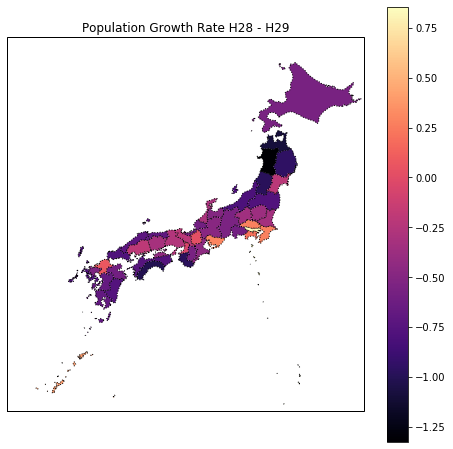

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shapereader
import pandas as pd
import numpy as np

# とにかく Unnamed 列の文字列を消去するための関数
def rename_unnamed(df): 
    """Rename unamed columns name for Pandas DataFrame

    See https://stackoverflow.com/questions/41221079/rename-multiindex-columns-in-pandas

    Parameters
    ----------
    df : pd.DataFrame object
        Input dataframe

    Returns
    -------
    pd.DataFrame
        Output dataframe

    """
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if "Unnamed: " in row:
                columns_new[j] = ""
        if pd.__version__ < "0.21.0":  # https://stackoverflow.com/a/48186976/716469
            df.columns.set_levels(columns_new, level=i, inplace=True)
        else:
            df = df.rename(columns=dict(zip(columns.tolist(), columns_new)),
                           level=i)
    return df


#　Excel データ読み込み
df = pd.read_excel("000494956.xls", sheet_name=0, header=[1,2,3], skiprows=[4])
# Omit "Unnamed" indices and adjust 
df = rename_unnamed(df)
df.set_index("都道府県名", inplace=True)
df.index.name="都道府県名"

shpfilename = shapereader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_1_states_provinces')

reader = shapereader.Reader(shpfilename)

provinces = []
for province in reader.records():
    if(province.attributes["admin"] == "Japan"):
        provinces.append(province)

plt.figure(figsize=[8,8])
ax = plt.axes(projection=ccrs.PlateCarree())

#　カラーマップのためのスケールデータ
cmap = plt.cm.magma
cnorm = max(df["平成28年","増減率"]) - min(df["平成28年","増減率"])
coff = min(df["平成28年","増減率"])

for province in provinces:
    geometry = province.geometry
    if province.attributes["name_local"] == "":
        continue
    color = cmap((df["平成28年","増減率"][province.attributes["name_local"]] - coff) / cnorm)
    ax.add_geometries(geometry, ccrs.PlateCarree(), edgecolor="black", linestyle=":",
                        facecolor=color)

ax.set_title("Population Growth Rate H28 - H29")

#ax.coastlines(resolution='10m')
ax.set_extent([125, 146, 25, 47])

sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(cnorm + coff,coff))
sm._A = []
plt.colorbar(sm,ax=ax)

plt.savefig("sample.pdf", dps = 900, bbox_inches="tight")
plt.show()